In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import xml.etree.ElementTree as ET
import torchvision.transforms.functional as FT
import json
import time
import utils
import numpy as np
import numpy.random as npr

In [2]:
# Set class labels

coin_labels = ('10c', '20c', '50c', '$1', '$2', '$5', '$10')

label_index_dict = {k:v+1 for v, k in enumerate(coin_labels)}
label_index_dict['background'] = 0
print(label_index_dict)

index_label_dict = {v+1:k for v, k in enumerate(coin_labels)}
index_label_dict[0] = 'background'
print(index_label_dict)

{'10c': 1, '20c': 2, '50c': 3, '$1': 4, '$2': 5, '$5': 6, '$10': 7, 'background': 0}
{1: '10c', 2: '20c', 3: '50c', 4: '$1', 5: '$2', 6: '$5', 7: '$10', 0: 'background'}


In [3]:
def parse_annotation(annotation_path):
    """
    Function to convert XML data of a single image into an object.
    The object contains Bbox parameters and the corresponding label for each Bbox.
    """

    # Parse the XML file into a tree structure
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    
    # Set initial lists
    boxes = list()
    labels = list()
    # difficulties = list()

    # Loop over each Bbox found in the XML file
    for object in root.iter('object'):

        # Convert Bbox co-ordinates
        bbox = object.find('bndbox')
        xmin = int(bbox.find('xmin').text) - 1 # TODO: Why minus 1?
        ymin = int(bbox.find('ymin').text) - 1
        xmax = int(bbox.find('xmax').text) - 1
        ymax = int(bbox.find('ymax').text) - 1
        boxes.append([xmin, ymin, xmax, ymax])

        # Convert Bbox Label
        label = object.find('name').text.lower().strip()
        if label not in label_index_dict:
            continue
        labels.append(label_index_dict[label])

        # Convert Bbox Difficulty
        # difficult = int(object.find('difficult').text == '1')
        # difficulties.append(difficult)

    return {'boxes': boxes, 'labels': labels}

In [9]:
from glob import glob
from pathlib import Path

def xml_to_json(files):
    """
    Function to convert image and XML data into two separate JSON objects.
    One object for images, and another object for Bbox co-ordinate values and labels.
    """
    
    # Initialise lists
    images_list = [] 
    objects_list = []
    
    # Set up two JSON files to be written
    images_file = open("TRAIN_images.json", 'w')
    objects_file = open("TRAIN_objects.json", 'w')
    
    # Iterate through each XML-Image pair
    for file in files:
    
        # Add each image file path into the images list
        file_path = os.path.splitext(file)[0]   
        images_list.append(file_path + ".jpg")
        
        # Add each XML object into the objects list
        xml_dict = parse_annotation(file)
        objects_list.append(xml_dict)
    
    # Write each list into the corresponding JSON files
    json.dump(images_list, images_file)
    json.dump(objects_list, objects_file)

CH_FILES = glob(r'dataset/ch dataset/*.xml')
# JY_FILES = glob(r'dataset/jy dataset/*.xml')
# HW_FILES = glob(r'dataset/hw dataset/*.xml')

xml_to_json(CH_FILES)
# xml_to_json(JY_FILES)
# xml_to_json(HW_FILES)

In [10]:
def resize(image, boxes, dims = (320, 320), return_percent_coords = False):
    """
    Adapted from: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py
    Resize image. For the SSD300, resize to (300, 300).
    Since percent/fractional coordinates are calculated for the bounding boxes (w.r.t image dimensions) in this process,
    you may choose to retain them.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: resized image, updated bounding box coordinates (or fractional coordinates, in which case they remain the same)
    """
    
    # Resize image
    new_image = FT.resize(image, dims)

    # Resize Bboxes
    old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
    new_boxes = boxes / old_dims  # percent coordinates

    if not return_percent_coords:
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        new_boxes = new_boxes * new_dims

    return new_image, new_boxes

In [11]:
def transform(image, boxes, labels):
    """
    Adapted from: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py
    Apply the transformations above.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :return: transformed image, transformed bounding box coordinates, transformed labels, transformed difficulties
    """

    # Mean and Standard deviation used for the base VGG from torchvision
    # See: https://pytorch.org/docs/stable/torchvision/models.html
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    new_image = image
    new_boxes = boxes
    new_labels = labels

    # Resize image - this also converts absolute boundary coordinates to their fractional form
    new_image, new_boxes = resize(new_image, new_boxes, dims = (320, 320))

    # Convert PIL image to Torch tensor
    new_image = FT.to_tensor(new_image)

    # Normalize by mean and standard deviation of ImageNet data that the base torchvision VGG was trained on
    new_image = FT.normalize(new_image, mean = mean, std = std)

    return new_image, new_boxes, new_labels

In [12]:
from torchvision import transforms

class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader.
    This class is primarily used to create batches.
    """
    
    def __init__(self, data_folder, split):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        """
        
        self.data_folder = data_folder
        self.split = split.upper()
        assert self.split in {'TRAIN', 'TEST'}

        # Read from the JSON files
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        # Number of images must match the number of objects containing the Bboxes for each image
        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):

        # Read image
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')
        image_tensor = transforms.ToTensor()(image)
        image_tensor = transforms.Resize(size = (320, 320))(image_tensor)

        # Read objects in this image (Bboxes, labels)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes']) # (n_objects, 4)
        labels = torch.LongTensor(objects['labels']) # (n_objects)

        # Apply transformations
        image, boxes, labels = transform(image, boxes, labels)

        return image_tensor, boxes, labels

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes. We use lists.
        Note: this need not be defined in this Class, can be standalone.
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])

        images = torch.stack(images, dim = 0)
        return images, boxes, labels  # tensor (N, 3, 300, 300), 3 lists of N tensors each

tensor([[[[0.6118, 0.6000, 0.6000,  ..., 0.7852, 0.7697, 0.7844],
          [0.6100, 0.5982, 0.5961,  ..., 0.7896, 0.7558, 0.8236],
          [0.6034, 0.6009, 0.5971,  ..., 0.7985, 0.7854, 0.8063],
          ...,
          [0.8118, 0.8074, 0.8044,  ..., 0.7137, 0.7142, 0.7137],
          [0.8118, 0.8091, 0.8105,  ..., 0.7203, 0.7231, 0.7228],
          [0.8085, 0.8063, 0.8078,  ..., 0.7207, 0.7180, 0.7099]],

         [[0.5961, 0.5922, 0.5922,  ..., 0.7852, 0.7697, 0.7844],
          [0.5943, 0.5903, 0.5882,  ..., 0.7896, 0.7558, 0.8236],
          [0.5956, 0.5930, 0.5892,  ..., 0.7946, 0.7815, 0.8063],
          ...,
          [0.8118, 0.8113, 0.8083,  ..., 0.7020, 0.7025, 0.7020],
          [0.8118, 0.8052, 0.8066,  ..., 0.7085, 0.7114, 0.7111],
          [0.8085, 0.8024, 0.8039,  ..., 0.7089, 0.7062, 0.6981]],

         [[0.6000, 0.5961, 0.5961,  ..., 0.7538, 0.7383, 0.7530],
          [0.5982, 0.5943, 0.5922,  ..., 0.7582, 0.7245, 0.7923],
          [0.5995, 0.5970, 0.5931,  ..., 0

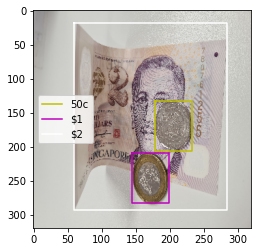

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

color_maps = ['r', 'g', 'b', 'y', 'm', 'w', 'k', 'c']
bs = 10
dataset = PascalVOCDataset(".", "TRAIN")
train_dataloader = DataLoader(dataset, batch_size = bs, shuffle = True, collate_fn = dataset.collate_fn)

# TODO: Currently, the object itself is being resized. 
# Need to instead use the resize() method to resize the bounding boxes instead?
# This should ideally be done in the Faster R-CNN network itself
# We'll need to ROI-Pool both the Bounding box Coordinates and the ROI itself

# Visualise data
for data in train_dataloader:
    count = 1
    if count == 1:
        print(data[0])
        print(data[0].size())
        print(data[0].type())
    count = count + 1
    for batch in range(bs):
        img = data[0][batch]
        boxes = data[1][batch]
        labels = data[2][batch].tolist()
        named_labels = [index_label_dict[label] for label in labels]
        plt.imshow(transforms.ToPILImage()(img))
        ax = plt.gca()
        labelled = set()
        for i, box in enumerate(boxes):
            w,h = box[2] - box[0], box[3] - box[1]
            x,y = box[0].item(), box[1].item()
            x = [x, x + w, x + w, x, x]
            y = [y, y, y + h, y + h, y]

            label = labels[i]
            if label not in labelled:
                plt.plot(x,y, color = color_maps[label], label = index_label_dict[label])
                labelled.add(label)
            else:
                plt.plot(x,y, color = color_maps[label])
            plt.legend(loc = 'best')
        break
    break

In [29]:
# Utils
BBOX_NORMALIZE_MEANS = (0.0, 0.0, 0.0, 0.0)
BBOX_NORMALIZE_STDS = (0.1, 0.1, 0.2, 0.2)
BBOX_INSIDE_WEIGHTS = (1.0, 1.0, 1.0, 1.0)

def pascal2yolo(anchor):
    """
    Transforms anchor coordinates of the form [xmin, ymin, xmax, ymax] to [x_center, y_center, width, height]
    """
    # TODO: +1? for width and height
    width = anchor[2] - anchor[0] + 1
    height = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + (width-1)/2 
    y_ctr = anchor[1] + (height-1)/2
    return width, height, x_ctr, y_ctr

def yolo2pascal(width, height, x_ctr, y_ctr):
    """
    Transforms anchor coordinates of the form [x_center, y_center, width, height] to [xmin, ymin, xmax, ymax]
    """
    width = width[:, np.newaxis]
    height = height[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (width - 1), y_ctr - 0.5 * (height - 1),
                         x_ctr + 0.5 * (width - 1), y_ctr + 0.5 * (height - 1)))
    return anchors

def generate_ratio_anchors(anchor, ratios=(0.5,1,2)):
    """
    Generate anchors based on given width:height ratio
    """
    w,h,x_ctr,y_ctr = pascal2yolo(anchor)
    size = w*h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = yolo2pascal(ws, hs, x_ctr, y_ctr)
    return anchors

def generate_scale_anchors(anchor, scales=np.array((8,16,32))):
    w,h,x_ctr,y_ctr = pascal2yolo(anchor)
    scaled_w = w * scales
    scaled_h = h * scales
    anchors = yolo2pascal(scaled_w, scaled_h, x_ctr, y_ctr)
    return anchors

def generate_anchors(height, width, aspect_ratio=np.array((0.5,1,2)), stride_length=16, scales=np.array((8,16,32))):
    # Generate anchors of differing scale and aspect ratios
    # return anchors and anchor length
    base_anchor = pascal2yolo([0,0,15,15])
    ratio_anchors = generate_ratio_anchors(base_anchor, ratios=aspect_ratio)
    anchors = []
    for i in range(ratio_anchors.shape[0]):
        anchors.append(generate_scale_anchors(ratio_anchors[i,:]), scales)
    anchors = np.stack(anchors)
    A = anchors.shape[0]
    shift_x = np.arange(0, width) * stride_length
    shift_y = np.arange(0, height) * stride_length
    # Shift each ratio and 
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(),
                        shift_y.ravel())).transpose()
    K = shifts.shape[0]
    # width changes faster, so here it is H, W, C
    anchors = anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose(
        (1, 0, 2))
    anchors = anchors.reshape((K * A, 4)).astype(np.float32, copy=False)
    length = np.int32(anchors.shape[0])

    return anchors, length

def bbox_transform(ex_rois, gt_rois):
    ex_widths = ex_rois[:, 2] - ex_rois[:, 0] + 1.0
    ex_heights = ex_rois[:, 3] - ex_rois[:, 1] + 1.0
    ex_ctr_x = ex_rois[:, 0] + 0.5 * ex_widths
    ex_ctr_y = ex_rois[:, 1] + 0.5 * ex_heights

    gt_widths = gt_rois[:, 2] - gt_rois[:, 0] + 1.0
    gt_heights = gt_rois[:, 3] - gt_rois[:, 1] + 1.0
    gt_ctr_x = gt_rois[:, 0] + 0.5 * gt_widths
    gt_ctr_y = gt_rois[:, 1] + 0.5 * gt_heights

    targets_dx = (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = torch.log(gt_widths / ex_widths)
    targets_dh = torch.log(gt_heights / ex_heights)

    targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh), 1)
    return targets

def bbox_overlaps(boxes, query_boxes):
    """
    Parameters
    ----------
    boxes: (N, 4) ndarray or tensor or variable
    query_boxes: (K, 4) ndarray or tensor or variable
    Returns
    -------
    overlaps: (N, K) overlap between boxes and query_boxes
    """
    if isinstance(boxes, np.ndarray):
        boxes = torch.from_numpy(boxes)
        query_boxes = torch.from_numpy(query_boxes)
        out_fn = lambda x: x.numpy()  # If input is ndarray, turn the overlaps back to ndarray when return
    else:
        out_fn = lambda x: x

    box_areas = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    query_areas = (query_boxes[:, 2] - query_boxes[:, 0] + 1) * (query_boxes[:, 3] - query_boxes[:, 1] + 1)

    iw = (torch.min(boxes[:, 2:3], query_boxes[:, 2:3].t()) - torch.max(boxes[:, 0:1], query_boxes[:, 0:1].t()) + 1).clamp(min=0)
    ih = (torch.min(boxes[:, 3:4], query_boxes[:, 3:4].t()) - torch.max(boxes[:, 1:2], query_boxes[:, 1:2].t()) + 1).clamp(min=0)
    ua = box_areas.view(-1, 1) + query_areas.view(1, -1) - iw * ih
    overlaps = iw * ih / ua
    return out_fn(overlaps)

def bbox_transform(ex_rois, gt_rois):
    ex_widths = ex_rois[:, 2] - ex_rois[:, 0] + 1.0
    ex_heights = ex_rois[:, 3] - ex_rois[:, 1] + 1.0
    ex_ctr_x = ex_rois[:, 0] + 0.5 * ex_widths
    ex_ctr_y = ex_rois[:, 1] + 0.5 * ex_heights

    gt_widths = gt_rois[:, 2] - gt_rois[:, 0] + 1.0
    gt_heights = gt_rois[:, 3] - gt_rois[:, 1] + 1.0
    gt_ctr_x = gt_rois[:, 0] + 0.5 * gt_widths
    gt_ctr_y = gt_rois[:, 1] + 0.5 * gt_heights

    targets_dx = (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = torch.log(gt_widths / ex_widths)
    targets_dh = torch.log(gt_heights / ex_heights)

    targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh), 1)
    return targets

def _compute_targets(ex_rois, gt_rois, labels):
    """Compute bounding-box regression targets for an image."""
    # Inputs are tensor

    targets = bbox_transform(ex_rois, gt_rois)

    # Normalize targets by a precomputed mean and stdev (optional)
    # targets = ((targets - targets.new(BBOX_NORMALIZE_MEANS)) / targets.new(BBOX_NORMALIZE_STDS))

    return torch.cat([labels.unsqueeze(1), targets], 1)

def _get_bbox_regression_labels(bbox_target_data, num_classes):
    """
    Bounding-box regression targets (bbox_target_data) are stored in a
    compact form N x (class, tx, ty, tw, th)
    This function expands those targets into the 4-of-4*K representation used
    by the network (i.e. only one class has non-zero targets).
    Returns:
        bbox_target (ndarray): N x 4K blob of regression targets
        bbox_inside_weights (ndarray): N x 4K blob of loss weights
    """
    # Inputs are tensor

    clss = bbox_target_data[:, 0]
    bbox_targets = clss.new_zeros(clss.numel(), 4 * num_classes)
    bbox_inside_weights = clss.new_zeros(bbox_targets.shape)
    inds = (clss > 0).nonzero().view(-1)
    if inds.numel() > 0:
        clss = clss[inds].contiguous().view(-1, 1)
        dim1_inds = inds.unsqueeze(1).expand(inds.size(0), 4)
        dim2_inds = torch.cat([4 * clss, 4 * clss + 1, 4 * clss + 2, 4 * clss + 3], 1).long()
        bbox_targets[dim1_inds, dim2_inds] = bbox_target_data[inds][:, 1:]
        bbox_inside_weights[dim1_inds, dim2_inds] = bbox_targets.new(BBOX_INSIDE_WEIGHTS).view(-1, 4).expand_as(dim1_inds)

    return bbox_targets, bbox_inside_weights

def bbox_transform_inv(boxes, deltas):
    # Input should be both tensor or both Variable and on the same device
    if len(boxes) == 0:
        return deltas.detach() * 0

    widths = boxes[:, 2] - boxes[:, 0] + 1.0
    heights = boxes[:, 3] - boxes[:, 1] + 1.0
    ctr_x = boxes[:, 0] + 0.5 * widths
    ctr_y = boxes[:, 1] + 0.5 * heights

    dx = deltas[:, 0::4]
    dy = deltas[:, 1::4]
    dw = deltas[:, 2::4]
    dh = deltas[:, 3::4]

    pred_ctr_x = dx * widths.unsqueeze(1) + ctr_x.unsqueeze(1)
    pred_ctr_y = dy * heights.unsqueeze(1) + ctr_y.unsqueeze(1)
    pred_w = torch.exp(dw) * widths.unsqueeze(1)
    pred_h = torch.exp(dh) * heights.unsqueeze(1)

    pred_boxes = torch.cat(\
      [_.unsqueeze(2) for _ in [pred_ctr_x - 0.5 * pred_w,\
                                pred_ctr_y - 0.5 * pred_h,\
                                pred_ctr_x + 0.5 * pred_w,\
                                pred_ctr_y + 0.5 * pred_h]], 2).view(len(boxes), -1)

    return pred_boxes

def clip_boxes(boxes, im_shape):
    """
  Clip boxes to image boundaries.
  boxes must be tensor or Variable, im_shape can be anything but Variable
  """

    if not hasattr(boxes, 'data'):
        boxes_ = boxes.numpy()

    boxes = boxes.view(boxes.size(0), -1, 4)
    boxes = torch.stack(\
      [boxes[:,:,0].clamp(0, im_shape[1] - 1),
       boxes[:,:,1].clamp(0, im_shape[0] - 1),
       boxes[:,:,2].clamp(0, im_shape[1] - 1),
       boxes[:,:,3].clamp(0, im_shape[0] - 1)], 2).view(boxes.size(0), -1)

    return boxes

def fix_sample_regions(fg_inds, bg_inds, gt_boxes, all_rois, rois_per_image):
    # Small modification to the original version where we ensure a fixed number of regions are sampled
    if fg_inds.numel() == 0 and bg_inds.numel() == 0:
        to_replace = all_rois.size(0) < rois_per_image
        bg_inds = torch.from_numpy(npr.choice(np.arange(0, all_rois.size(0)), size=int(rois_per_image), replace=to_replace)).long().cuda()
        fg_rois_per_image = 0
    elif fg_inds.numel() > 0 and bg_inds.numel() > 0:
        fg_rois_per_image = min(fg_rois_per_image, fg_inds.numel())
        fg_inds = fg_inds[torch.from_numpy(
            npr.choice(
                np.arange(0, fg_inds.numel()),
                size=int(fg_rois_per_image),
                replace=False)).long().to(gt_boxes.device)]
        bg_rois_per_image = rois_per_image - fg_rois_per_image
        to_replace = bg_inds.numel() < bg_rois_per_image
        bg_inds = bg_inds[torch.from_numpy(
            npr.choice(
                np.arange(0, bg_inds.numel()),
                size=int(bg_rois_per_image),
                replace=to_replace)).long().to(gt_boxes.device)]
    elif fg_inds.numel() > 0:
        to_replace = fg_inds.numel() < rois_per_image
        fg_inds = fg_inds[torch.from_numpy(
            npr.choice(
                np.arange(0, fg_inds.numel()),
                size=int(rois_per_image),
                replace=to_replace)).long().to(gt_boxes.device)]
        fg_rois_per_image = rois_per_image
    elif bg_inds.numel() > 0:
        to_replace = bg_inds.numel() < rois_per_image
        bg_inds = bg_inds[torch.from_numpy(
            npr.choice(
                np.arange(0, bg_inds.numel()),
                size=int(rois_per_image),
                replace=to_replace)).long().to(gt_boxes.device)]
        fg_rois_per_image = 0

    return fg_inds, bg_inds, gt_boxes, all_rois, rois_per_image

In [176]:
from torch import nn
import torch.nn.functional as F
from torchvision.ops import nms, RoIAlign

hidden_dim = 64
nb_objects = 3 # TODO: How about cases where images have different number of objects?
num_of_class = 7

im_size = 320
ob_size = 20 # TODO: How about cases where objects have different sizes? Currently, H = W = ob_size
batch_size= 2
offset = (ob_size-1) // 2

# Thresholds
FG_THRESH = 0.5 # Overlap threshold for a ROI to be considered foreground (if >= FG_THRESH)
# Overlap threshold for a ROI to be considered background (class = 0 if overlap in [LO, HI))
BG_THRESH_HI = 0.5
BG_THRESH_LO = 0.1

PRE_NMS_TOPN = 12000
POST_NMS_TOPN = 2000
NMS_THRESH = 0.7

POSITIVE_OVERLAP = 0.7
NEGATIVE_OVERLAP = 0.3
CLOBBER_POSITIVES = False
RPN_BS = 256
FG_FRACTION = 0.5
RPN_POSITIVE_WEIGHT = -1.0
POOLING_SIZE = 7

class faster_R_CNN(nn.Module):
    """
    The main Faster R-CNN network used for this project.
    """
    
    def __init__(self):
        super(faster_R_CNN, self).__init__()
        self.feat_stride = [16,]
        self._predictions = {}
        self._losses = {}
        self._anchor_targets = {}
        self._proposal_targets = {}
        self._layers = {}
        self._fc_channels = 4096
        self._net_conv_channels = 1024
        
        # This results in num_anchors = 9
        anchor_scales = (8, 16, 32)
        anchor_ratios = (0.5, 1, 2)
        self._num_anchors = len(anchor_scales) * len(anchor_ratios)  
        
        # HeadNet: Generating a series of Feature maps from the input image
        
        # Current Size: 3 x h x w
        self.head_conv1 = nn.Conv2d(3,  hidden_dim,  kernel_size=4, stride=2, padding=1)
        # Current Size: 64 x h/2 x w/2
        self.head_batch_norm1 = nn.BatchNorm2d(hidden_dim)
        # Current Size: 64 x h/2 x w/2 
        self.head_relu1 = nn.ReLU()
        # Current Size: 64 x h/2 x w/2
        self.head_pool1 = nn.MaxPool2d([3,3], 1)
        # Current Size: 64 x h/4 x w/4
        self.head_layer1 = nn.Conv2d(hidden_dim,  hidden_dim*4,  kernel_size=3, padding=1)
        self.head_relu2 = nn.ReLU()
        # Current Size: 256 x h/4 x w/4
        self.head_layer2 = nn.Conv2d(hidden_dim*4,  hidden_dim*8,  kernel_size=3, padding=1)
        self.head_pool2 = nn.MaxPool2d([3,3], 1)
        self.head_relu3 = nn.ReLU()
        # Current Size: 512 x h/8 x w/8
        self.head_layer3 = nn.Conv2d(hidden_dim*8,  hidden_dim*16,  kernel_size=3, padding=1)
        self.head_pool3 = nn.MaxPool2d([3,3], 1)
        self.head_relu4 = nn.ReLU()
        # Current Size: 1024 x h/16 x w/16
        
        # Current Size: n x 1024 x 7 x 7
        self.fc7_layer = nn.Conv2d(self._predictions["rois"].size(0), self._predictions["rois"].size(0),  kernel_size=3, padding=1)
        self.fc7_pool = nn.AvgPool2d([3,3], 1)
        # Current Size: n x 4096 x 3 x 3
        
        # Region Proposal Network
        self.rpn_net = nn.Conv2d(self._net_conv_channels,512 ,[3,3], padding=1)
        self.rpn_cls_score_net = nn.Conv2d(512, self._num_anchors*2, [1,1])
        self.rpn_bbox_pred_net = nn.Conv2d(512, self._num_anchors*4, [1,1])

        # Classification Network
        self.cls_score_net = nn.Linear(self._fc_channels, num_of_class)
        self.bbox_pred_net = nn.Linear(self._fc_channels, num_of_class*4)

    def head_net(self):
        return nn.Sequential(
            self.head_conv1,
            self.head_batch_norm1,
            self.head_relu1,
            self.head_pool1,
            self.head_layer1,
            self.head_relu2,
            self.head_layer2,
            self.head_pool2,
            self.head_relu3,
            self.head_layer3,
            self.head_pool3,
            self.head_relu4
        )

    def fc7(self):
        return nn.Sequential(
            self.fc7_layer,
            self.fc7_pool
        )
        
    def proposal_layer(self, cls_prob, bbox_pred):
        '''
        Prunes no. of boxes using NMS based on fg scores and transforms bbox using regression coeff
        '''
        
        # Get the scores and bounding boxes
        scores = cls_prob[:, :, :, num_anchors:]
        rpn_bbox_pred = bbox_pred.view((-1, 4))
        scores = scores.contiguous().view(-1, 1)
        proposals = bbox_transform_inv(anchors, rpn_bbox_pred) # shift boxes based on prediction
        proposals = clip_boxes(proposals, self._im_info[:2])

        # Pick the top region proposals
        scores, order = scores.view(-1).sort(descending=True)
        if PRE_NMS_TOPN > 0:
            order = order[:PRE_NMS_TOPN]
            scores = scores[:PRE_NMS_TOPN].view(-1, 1)
        proposals = proposals[order.data, :]

        # Non-maximal suppression
        keep = nms(proposals, scores.squeeze(1), NMS_THRESH)

        # Pick the top region proposals after NMS
        if POST_NMS_TOPN > 0:
            keep = keep[:POST_NMS_TOPN]
        proposals = proposals[keep, :]
        scores = scores[keep, ]

        # Only support single image as input
        batch_inds = proposals.new_zeros(proposals.size(0), 1)
        blob = torch.cat((batch_inds, proposals), 1)

        return blob, scores

    # def anchor_target_layer(self, rpn_cls_score, gt_boxes, im_info, all_anchors, num_anchors):    
    def anchor_target_layer(self, rpn_cls_score, gt_boxes, all_anchors):

        '''

        ### Parameters ###
        rpn_cls_score: Class scores generated by the Region Proposal Network
        gt_boxes: Ground Truth boxes
        all_anchors: Anchor boxes generated by the anchor generation layer
        
        ### Fixed Parameters ###
        im_info: Image dimensions
        num_anchors: Number of different Anchor boxes used. By default, it is set to 9 here.

        ### Additional information ###
        POSITIVE_OVERLAP:       Threshold used to select if an anchor box is a good foreground box (Default: 0.7)

        NEGATIVE_OVERLAP:       If the max overlap of a anchor from a ground truth box is lower than this thershold, it is marked as background. 
                                Boxes whose overlap is > than NEGATIVE_OVERLAP but < POSITIVE_OVERLAP are marked 
                                “don’t care”. (Default: 0.3)
        
        CLOBBER_POSITIVES:      If a particular anchor is satisfied by both the positive and the negative conditions,
                                and if this value is set to False, then set the anchor to a negative example.
                                Else, set the anchor to a positive example.
        
        RPN_BS:                 Total number of background and foreground anchors. (Default: 256)
        
        FG_FRACTION:            Fraction of the batch size that is foreground anchors (Default: 0.5). 
                                If the number of foreground anchors found is larger than RPN_BS * FG_FRACTION, 
                                the excess (indices are selected randomly) is marked “don’t care”.
                            
        RPN_POSITIVE_WEIGHT:    Using this value:
                                Positive RPN examples are given a weight of RPN_POSITIVE_WEIGHT * 1 / num_of_positives
                                Negative RPN examples are given a weight of (1 - RPN_POSITIVE_WEIGHT)
                                Set to -1 by default, which will ensure uniform example weighting.

        '''

        # Map of shape (..., H, W)
        height, width = rpn_cls_score.shape[1:3]

        # Only keep anchors that are completely inside the image
        inds_inside = np.where(
            (all_anchors[:, 0] >= 0) &
            (all_anchors[:, 1] >= 0) &
            (all_anchors[:, 2] < im_info[1]) &  # width
            (all_anchors[:, 3] < im_info[0])  # height
        )[0]
        anchors = all_anchors[inds_inside, :]

        # Label: 1 is positive, 0 is negative, -1 is dont care
        labels = np.empty((len(inds_inside), ), dtype=np.float32)
        labels.fill(-1)

        # Overlaps between the Anchors and the Ground Truth boxes
        overlaps = bbox_overlaps(
            np.ascontiguousarray(anchors, dtype=np.float),
            np.ascontiguousarray(gt_boxes, dtype=np.float))
        argmax_overlaps = overlaps.argmax(axis=1)
        max_overlaps = overlaps[np.arange(len(inds_inside)), argmax_overlaps]
        gt_argmax_overlaps = overlaps.argmax(axis=0)
        gt_max_overlaps = overlaps[gt_argmax_overlaps, np.arange(overlaps.shape[1])]
        gt_argmax_overlaps = np.where(overlaps == gt_max_overlaps)[0]

        # Set anchors whose overlap < NEGATIVE_OVERLAP to a negative example
        # "Positives clobber Negatives"
        if not CLOBBER_POSITIVES:
            labels[max_overlaps < NEGATIVE_OVERLAP] = 0

        # Foreground label: for each Ground Truth box, anchor with highest overlap
        labels[gt_argmax_overlaps] = 1

        # Foreground label: above threshold IOU
        labels[max_overlaps >= POSITIVE_OVERLAP] = 1

        # Set anchors whose overlap < NEGATIVE_OVERLAP to a negative example
        # "Negatives clobber Positives"
        if CLOBBER_POSITIVES:
            labels[max_overlaps < NEGATIVE_OVERLAP] = 0

        # Subsample positive labels if we have too many
        num_fg = int(FG_FRACTION * RPN_BS)
        fg_inds = np.where(labels == 1)[0]
        if len(fg_inds) > num_fg:
            disable_inds = npr.choice(fg_inds, size=(len(fg_inds) - num_fg), replace=False)
            labels[disable_inds] = -1

        # Subsample negative labels if we have too many
        num_bg = RPN_BS - np.sum(labels == 1)
        bg_inds = np.where(labels == 0)[0]
        if len(bg_inds) > num_bg:
            disable_inds = npr.choice(bg_inds, size=(len(bg_inds) - num_bg), replace=False)
            labels[disable_inds] = -1

        bbox_targets = np.zeros((len(inds_inside), 4), dtype=np.float32)
        bbox_targets = _compute_targets(anchors, gt_boxes[argmax_overlaps, :])

        bbox_inside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
        # Only the positive ones have regression targets
        bbox_inside_weights[labels == 1, :] = np.array((1.0, 1.0, 1.0, 1.0))

        bbox_outside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
        if RPN_POSITIVE_WEIGHT < 0:
            # Uniform weighting of examples (given non-uniform sampling)
            num_examples = np.sum(labels >= 0)
            positive_weights = np.ones((1, 4)) * 1.0 / num_examples
            negative_weights = np.ones((1, 4)) * 1.0 / num_examples
        else:
            assert ((RPN_POSITIVE_WEIGHT > 0) &
                    (RPN_POSITIVE_WEIGHT < 1))
            positive_weights = (
                RPN_POSITIVE_WEIGHT / np.sum(labels == 1))
            negative_weights = (
                (1.0 - RPN_POSITIVE_WEIGHT) / np.sum(labels == 0))
        bbox_outside_weights[labels == 1, :] = positive_weights
        bbox_outside_weights[labels == 0, :] = negative_weights

        # Map up to original set of anchors
        total_anchors = all_anchors.shape[0]
        labels = _unmap(labels, total_anchors, inds_inside, fill=-1)
        bbox_targets = _unmap(bbox_targets, total_anchors, inds_inside, fill=0)
        bbox_inside_weights = _unmap(
            bbox_inside_weights, total_anchors, inds_inside, fill=0)
        bbox_outside_weights = _unmap(
            bbox_outside_weights, total_anchors, inds_inside, fill=0)

        # Labels
        labels = labels.reshape((1, height, width, num_anchors)).transpose(0, 3, 1, 2)
        labels = labels.reshape((1, 1, num_anchors * height, width))
        rpn_labels = labels

        # Bounding boxes
        bbox_targets = bbox_targets.reshape((1, height, width, num_anchors * 4))
        rpn_bbox_targets = bbox_targets
        bbox_inside_weights = bbox_inside_weights.reshape((1, height, width, num_anchors * 4))
        rpn_bbox_inside_weights = bbox_inside_weights
        bbox_outside_weights = bbox_outside_weights.reshape((1, height, width, num_anchors * 4))
        rpn_bbox_outside_weights = bbox_outside_weights

        # Re-shape for future use
        rpn_labels = torch.from_numpy(rpn_labels).float() #.set_shape([1, 1, None, None])
        rpn_bbox_targets = torch.from_numpy(rpn_bbox_targets).float() #.set_shape([1, None, None, self._num_anchors * 4])
        rpn_bbox_inside_weights = torch.from_numpy(rpn_bbox_inside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
        rpn_bbox_outside_weights = torch.from_numpy(rpn_bbox_outside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
        rpn_labels = rpn_labels.long()

        # Data storing
        self._anchor_targets['rpn_labels'] = rpn_labels
        self._anchor_targets['rpn_bbox_targets'] = rpn_bbox_targets
        self._anchor_targets['rpn_bbox_inside_weights'] = rpn_bbox_inside_weights
        self._anchor_targets['rpn_bbox_outside_weights'] = rpn_bbox_outside_weights

        for k in self._anchor_targets.keys():
            self._score_summaries[k] = self._anchor_targets[k]

        return rpn_labels
        
    def proposal_target_layer(self, proposed_rois, proposed_roi_scores):
        '''
        1. Calculate overlap between ROI and GT boxes
        2. Select promising ROIs by comparing against threshold(s)
        3. Compute bounding box target regression targets and get bounding box regression labels
        '''
        # Proposal ROIs (0, x1, y1, x2, y2) coming from RPN
        gt_boxes = self._gt_boxes

        num_images = 1
        rois_per_image = RPN_BS / num_images
        fg_rois_per_image = int(round(FG_FRACTION * rois_per_image))

        # Sample rois with classification labels and bounding box regression targets
        # overlaps: (rois x gt_boxes)
        overlaps = bbox_overlaps(proposed_rois[:, 1:5].data, gt_boxes[:, :4].data)
        max_overlaps, gt_assignment = overlaps.max(1)
        labels = gt_boxes[gt_assignment, [4]]

        # Select foreground RoIs as those with >= FG_THRESH overlap
        fg_inds = (max_overlaps >= FG_THRESH).nonzero().view(-1)
        
        # Guard against the case when an image has fewer than fg_rois_per_image
        # Select background RoIs as those within [BG_THRESH_LO, BG_THRESH_HI)
        bg_inds = ((max_overlaps < BG_THRESH_HI) + (max_overlaps >= BG_THRESH_LO) == 2).nonzero().view(-1)

        # Ensure a fixed number of regions are sampled (optional?)
        fg_inds, bg_inds, gt_boxes, proposed_rois, rois_per_image = fix_sample_regions(fg_inds, bg_inds, gt_boxes, proposed_rois, rois_per_image)
        
        # The indices that we're selecting (both fg and bg)
        keep_inds = torch.cat([fg_inds, bg_inds], 0)

        # Select sampled values from various arrays:
        labels = labels[keep_inds].contiguous()

        # Clamp labels for the background RoIs to 0
        labels[int(fg_rois_per_image):] = 0
        rois_final = proposed_rois[keep_inds].contiguous()
        roi_scores_final = proposed_roi_scores[keep_inds].contiguous()

        # Compute bounding box target regression targets
        bbox_target_data = _compute_targets(rois_final[:, 1:5].data, gt_boxes[gt_assignment[keep_inds]][:, :4].data, labels.data)
        bbox_targets, bbox_inside_weights = _get_bbox_regression_labels(bbox_target_data, nb_class_objects)

        # Reshape tensors
        rois = rois.view(-1, 5)
        roi_scores = roi_scores.view(-1)
        labels = labels.view(-1, 1)
        bbox_targets = bbox_targets.view(-1, nb_class_objects * 4)
        bbox_inside_weights = bbox_inside_weights.view(-1, nb_class_objects * 4)
        bbox_outside_weights = (bbox_inside_weights > 0).float()
        
        self._proposal_targets['rois'] = rois
        self._proposal_targets['labels'] = labels.long()
        self._proposal_targets['bbox_targets'] = bbox_targets
        self._proposal_targets['bbox_inside_weights'] = bbox_inside_weights
        self._proposal_targets['bbox_outside_weights'] = bbox_outside_weights

        return rois, roi_scores
        
    def region_proposal(self, net_conv):
        """
        Input: features from head network
        Output: rois
        1. Proposal Layer
        2. Anchor Target Layer
        3. Compute RPN Loss
        4. Proposal Target Layer
        
        Features -> class probabilities of anchors(fg or bg) and bbox coeff of anchors (to adjust them)
        """
                                       
        # TODO: Note down dimensions of features for each function
        rpn = F.relu(self.rpn_net(net_conv))
        rpn_cls_score = self.rpn_cls_score_net(rpn)
                                       
        rpn_cls_score_reshape = rpn_cls_score.view(1, 2, -1, rpn_cls_score.size()[-1]) # batch * 2 * (num_anchors*h) * w
        rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape, dim=1)

        # Move channel to the last dimenstion, to fit the input of python functions
        rpn_cls_prob = rpn_cls_prob_reshape.view_as(rpn_cls_score).permute(0, 2, 3, 1) # batch * h * w * (num_anchors * 2)
        rpn_cls_score = rpn_cls_score.permute(0, 2, 3, 1) # batch * h * w * (num_anchors * 2)
        rpn_cls_score_reshape = rpn_cls_score_reshape.permute(0, 2, 3, 1).contiguous() # batch * (num_anchors*h) * w * 2
        rpn_cls_pred = torch.max(rpn_cls_score_reshape.view(-1, 2), 1)[1]

        rpn_bbox_pred = self.rpn_bbox_pred_net(rpn)
        rpn_bbox_pred = rpn_bbox_pred.permute(0, 2, 3, 1).contiguous()  # batch * h * w * (num_anchors*4)                  

        if self.mode == 'TRAIN':
            rois, roi_scores = self.proposal_layer(rpn_cls_prob, rpn_bbox_pred, stride=16, anchors=anchors, num_anchors=n_anchors)
            rpn_labels = self.anchor_target_layer(rpn_cls_score)
            rois, _ = self.proposal_target_layer(rois, roi_scores)
        else:
            pass
        
        self._predictions["rpn_cls_score"] = rpn_cls_score
        self._predictions["rpn_cls_score_reshape"] = rpn_cls_score_reshape
        self._predictions["rpn_cls_prob"] = rpn_cls_prob
        self._predictions["rpn_cls_pred"] = rpn_cls_pred
        self._predictions["rpn_bbox_pred"] = rpn_bbox_pred
        self._predictions["rois"] = rois
        
        return rois
    
    def _roi_align_layer(self, bottom, rois):
        return RoIAlign((POOLING_SIZE, POOLING_SIZE), 1.0 / 16.0, 0)(bottom, rois)
    
    def region_classification(self, fc7):
        """
        cls_score
            Linear layer (fc7 channels, num_classes)
            torch max
            softmax
        bbox_pred
            Linear layer (fc7 channels, num_classes*4)
        """
        cls_score = self.cls_score_net(fc7)
        cls_pred = torch.max(cls_score, 1)[1]
        cls_prob = F.softmax(cls_score, dim=1)
        bbox_pred = self.bbox_pred_net(fc7)
        
        self._predictions["cls_score"] = cls_score
        self._predictions["cls_pred"] = cls_pred
        self._predictions["cls_prob"] = cls_prob
        self._predictions["bbox_pred"] = bbox_pred

        return cls_prob, bbox_pred

    def add_losses(self, sigma_rpn=3.0):
                                       
        # RPN, class loss
        rpn_cls_score = self._predictions['rpn_cls_score_reshape'].view(-1, 2)
        rpn_label = self._anchor_targets['rpn_labels'].view(-1)
        rpn_select = (rpn_label.data != -1).nonzero().view(-1)
        rpn_cls_score = rpn_cls_score.index_select(0, rpn_select).contiguous().view(-1, 2)
        rpn_label = rpn_label.index_select(0, rpn_select).contiguous().view(-1)
        rpn_cross_entropy = F.cross_entropy(rpn_cls_score, rpn_label)

        # RPN, bbox loss
        rpn_bbox_pred = self._predictions['rpn_bbox_pred']
        rpn_bbox_targets = self._anchor_targets['rpn_bbox_targets']
        rpn_bbox_inside_weights = self._anchor_targets['rpn_bbox_inside_weights']
        rpn_bbox_outside_weights = self._anchor_targets['rpn_bbox_outside_weights']
        rpn_loss_box = self._smooth_l1_loss(
            rpn_bbox_pred,
            rpn_bbox_targets,
            rpn_bbox_inside_weights,
            rpn_bbox_outside_weights,
            sigma=sigma_rpn,
            dim=[1, 2, 3])

        # RCNN, class loss
        cls_score = self._predictions["cls_score"]
        label = self._proposal_targets["labels"].view(-1)
        cross_entropy = F.cross_entropy(cls_score.view(-1, self._num_classes), label)

        # RCNN, bbox loss
        bbox_pred = self._predictions['bbox_pred']
        bbox_targets = self._proposal_targets['bbox_targets']
        bbox_inside_weights = self._proposal_targets['bbox_inside_weights']
        bbox_outside_weights = self._proposal_targets['bbox_outside_weights']
        loss_box = self._smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights)

        self._losses['cross_entropy'] = cross_entropy
        self._losses['loss_box'] = loss_box
        self._losses['rpn_cross_entropy'] = rpn_cross_entropy
        self._losses['rpn_loss_box'] = rpn_loss_box

        loss = cross_entropy + loss_box + rpn_cross_entropy + rpn_loss_box
        self._losses['total_loss'] = loss

        for k in self._losses.keys():
            self._event_summaries[k] = self._losses[k]

        return loss                                       

    def forward(self, x, im_info, bb, train_flag=True):
        
        # Store image information
        self._im_info = im_info
                                       
        # Pass the image through the Backbone ConvNet to generate the series of Feature maps
        head_conv_net = self.head_net()
        output_head = head_conv_net(x)
        anchors, length = generate_anchors(output_head.size(2), output_head.size(3))
        rois = self.region_proposal(output_head)
        pool5 = self._roi_align_layer(output_head, rois)
        cls_prob, bbox_pred = self._region_classification(self.fc7(pool5))
        loss = self.add_losses()

#         # Using x, the generated series of Feature maps (64 x H x W):
        
#         # (1) Predict Bbox Anchor positions
#         scores_bbox_anch = self.conv_bbox_anch(x).squeeze()
        
#         # (2.1) Predict Classifications for Bboxes
#         # If this is during training time, only need to predict Bbox classifications
#         if train_flag:
            
#             # Initialise list
#             bbox_list = []
            
#             # Iterate through each Bbox in an image, in each batch
#             for b in range(batch_size):
#                 for k in range(nb_objects):
#                     xmin = bb[b][k, 0].long()
#                     ymin = bb[b][k, 1].long()
#                     xmax = bb[b][k, 2].long() # xmax - xmin = width
#                     ymax = bb[b][k, 3].long() # ymax - ymin = height
#                     bbox_list.append(x[b,:,xmin:xmax,ymin:ymax])

#             # TODO: Objects may have different sizes
#             for i in range(len(bbox_list)):
#                 print(bbox_list[i].size())
#             assert bbox_list[0].size() == bbox_list[1].size() # Quick check
            
#             # Current size: batch_size*nb_objects x hidden_dim x H x W
#             bbox_list = torch.stack(bbox_list, dim = 0)

#             # Current size: batch_size*nb_objects x hidden_dim*H*W
#             bbox_list = bbox_list.view(-1, hidden_dim * ob_size**2)
            
#             # Current size: batch_size*nb_objects x num_of_class
#             scores_bbox_class = self.linear_bbox_class(bbox_list)

#         # (2.2) Predict Classifications for Bboxes
#         # If this is during test time, go one step further to find the co-ordinates of the Bboxes
#         else:
            
#             # Initialise list
#             batch_bbox_list = []
            
#             # Iterate through each batch
#             for b in range(batch_size):
                
#                 # For each image, we assume that there are K number of objects
#                 # TODO: What if there are different numbers of objects?
#                 # We first compute the co-ordinates of the top K Bboxes in terms of Anchor scores
#                 scores_bbox_anch_b = scores_bbox_anch[b,:,:]
#                 scores_bbox_anch_b = scores_bbox_anch_b.view(-1)
#                 _, idx_largest = torch.sort(scores_bbox_anch_b, descending = True)
#                 idx_largest = idx_largest[:nb_objects]
                
#                 # We can calculate the y-coordinate and the x-coordinate separately
#                 idx_y = idx_largest // im_size # [nb_objects]
#                 idx_x = idx_largest - (idx_y * im_size) # [nb_objects]
#                 print(idx_largest)
#                 print(idx_y)
#                 print(idx_x)
                
#                 # We then extract the top K Bboxes in terms of Anchor scores
#                 bbox = []
#                 for k in range(nb_objects):
#                     xmin = idx_x[k] - offset
#                     ymin = idx_y[k] - offset
#                     xmax = idx_x[k] - offset + ob_size # xmax - xmin = width
#                     ymax = idx_y[k] - offset + ob_size # ymax - ymin = height
#                     bbox.append(x[b,:,ymin:ymax,xmin:xmax])
                
#                 # Current size: nb_objects x hidden_dim x H x W
#                 bbox = torch.stack(bbox, dim = 0)

#                 # Current size: nb_objects x hidden_dim*H*W
#                 bbox = bbox.view(-1, hidden_dim * ob_size**2)
#                 batch_bbox_list.append(bbox)

#             # Once we have run through all the batches, we can compute the class scores of the Bboxes
            
#             # Current size: batch_size*nb_objects x hidden_dim*H*W
#             batch_bbox_list = torch.cat(batch_bbox_list, dim=0)
                
#             # Current size: batch_size*nb_objects x num_of_class            
#             scores_bbox_class = self.linear_bbox_class(batch_bbox_list)
        
#         # Return the results from (1) and (2.1) / (2.2)
#         return scores_bbox_class, scores_bbox_anch

In [177]:
# device = torch.device('cuda')
device = torch.device('cpu')

net = faster_R_CNN()
net.to(device)

print(net)
print(utils.display_num_param(net))

faster_R_CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bbox_anch): Conv2d(64, 1, kernel_size=(20, 20), stride=(1, 1), padding=(9, 9))
  (linear_bbox_class): Linear(in_features=25600, out_features=7, bias=True)
)
There are 243528 (0.24 million) parameters in this neural network
None


In [178]:
# Set initial learning rate and Optimizer
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr = init_lr)

# Set training variables
running_loss = 0
num_batches = 0
start = time.time()

# Training process
for epoch in range(10):
    for data in train_dataloader:
        
        batch_images, batch_bboxes = data[0], data[1]
        optimizer.zero_grad()
        scores_bbox_class, scores_bbox_anch = net(batch_images, batch_bboxes)
        
        # Bbox class loss
        labels_bbox_class = batch_bboxes[:,:,4].long().view(-1) # [batch_size*nb_objects]
        loss_class = nn.CrossEntropyLoss()(scores_bbox_class, labels_bbox_class)
        
        # Bbox anchors loss
        labels_bbox_coord = batch_bboxes[:,:,0:2] # [batch_size, nb_objects, 2D]
        labels_bbox_anch = torch.zeros(batch_size, im_size, im_size) # [batch_size, im_size, im_size]
        for b in range(batch_size):
            for k in range(nb_objects): 
                labels_bbox_anch[b,labels_bbox_coord[b,k,1].long(),labels_bbox_coord[b,k,0].long()] = 1
        
        loss_anch = torch.nn.BCEWithLogitsLoss()(scores_bbox_anch, labels_bbox_anch)
        loss = loss_class + loss_anch
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().item()
        num_batches += 1

    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', init_lr  ,'\t loss=', total_loss )

torch.Size([64, 122, 148])
torch.Size([64, 22, 27])
torch.Size([64, 34, 44])
torch.Size([64, 35, 48])
torch.Size([64, 26, 35])
torch.Size([64, 33, 47])


AssertionError: 